In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

# 1. Import Libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Activation, ZeroPadding2D, LeakyReLU, ReLU, UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam

# 2. Load Data

In [4]:
df_original = pd.read_csv('emnist-letters-train.csv', header=None)
df_original

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,16,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99035,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99036,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99037,19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99038,-1,174,174,174,174,174,174,174,174,174,...,174,174,174,174,174,174,174,174,174,174


From the dataframe shown above, we can see that there are 785 different columns and 99040 different rows. After some analysis of the data in excel, we hypothesized that column 0 is the label column which identifies what alphabet the image would represent in its number-letter correspondence (with -1 representing a blank image) and the rest of the columns are pixel values. Hence for each row, we have 1 label value and 784 pixel values which can be nicely reshaped into a 28x28 image

To confirm our hypothesis, we will do some data analysis of the dataset

# 3. Exploratory Data Aanalysis

Get all the labels in the dataset

In [5]:
alphabets = df_original.iloc[:, 0]
alphabets

0        23
1         7
2        16
3        15
4        23
         ..
99035    18
99036    24
99037    19
99038    -1
99039    -1
Name: 0, Length: 99040, dtype: int64

Get all the pixel values in the dataset

In [6]:
df = df_original.iloc[:, 1:]
df

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99038,174,174,174,174,174,174,174,174,174,174,...,174,174,174,174,174,174,174,174,174,174


## y-label Analysis

As we all know, there are 26 different alphabets in the English language. Hence we should have 26 different labels in the dataset if our hypothesis is correct

In [7]:
np.sort(alphabets.unique())

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=int64)

In [8]:
len(alphabets.unique())

27

However, we can see that there are actually 27 different unique labels in the dataset with the values ranging from 1 to 26 and -1. Let's try to find out what -1 represents and whether labels 1-26 are the alphabets' number-letter correspondence by plotting them out as images

Before that, we need to do some data preprocessing to be able to plot out our images. As we can see from the datasets above, every row contains pixel values for every image in the form of a 1D array in as there are 784 columns which can be reshaped into a 28x28 array. We need to reshape them into 2D arrays to visualize them

## Pixel Values

In [9]:
print(f'Highest pixel value: {df.max().max()}')
print(f'Lowest pixel value: {df.min().min()}')

Highest pixel value: 255
Lowest pixel value: 0


The pixel values of the dataset ranges from 0 to 255 which confirms our hypothesis that the columns 1-785 are pixel values

## Data Preprocessing

In [10]:
def createMatrix(df):
    """
    Gets the pixel value from each row and reshapes it into a 28x28 matrix
    """
    arr = []

    for row in range(len(df)):
        img = df.iloc[row, :].values.reshape((28, 28))
        arr.append(img)

    arr = np.array(arr)
    print(arr.shape)

    return arr

In [11]:
imageArr = createMatrix(df)

(99040, 28, 28)


## Plot Images

Using plt.imshow(), we can visualise our transformed 2D arrays as grayscale images

In [12]:
def imageSubplot(arr, numberOfImages, titles=None):
    """
    Plots a 3 by `numberOfImages` grid of images
    """
    plt.figure()

    for i in range(numberOfImages):
        plt.subplot(numberOfImages // 3, 3, i+1)  
        plt.imshow(arr[i], cmap='gray')
        plt.axis('off')
        if titles:
            plt.title(titles[i])
        else:
            plt.title(f'Image {i+1}')

    plt.tight_layout()  
    plt.show()

### -1 Labelled Image

Locate the indexes for the images labelled -1

In [13]:
df_original[df_original.iloc[:, 0] == -1].index

Index([   20,    30,    31,    36,    39,    41,    56,    65,    74,    75,
       ...
       98979, 99003, 99007, 99010, 99012, 99020, 99023, 99034, 99038, 99039],
      dtype='int64', length=10240)

In [14]:
blankArr = [imageArr[20], imageArr[30], imageArr[31]]

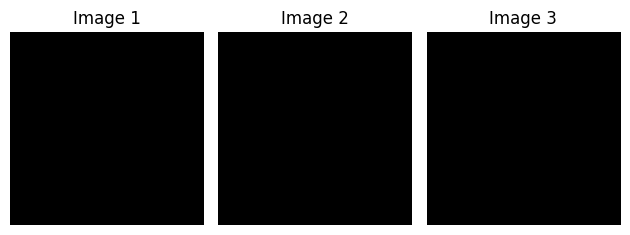

In [15]:
imageSubplot(blankArr, len(blankArr))

From the image plots above, we can see that the images labelled -1 are blank images. Hence we can conclude that -1 represents a blank image

### Alphabet Images

Plot out first 6 images of the dataset

In [16]:
first6labels = df_original.iloc[:6, 0].values
first6alphabets = list(map(lambda x: f'{x}: {chr(x + 96)}', first6labels))

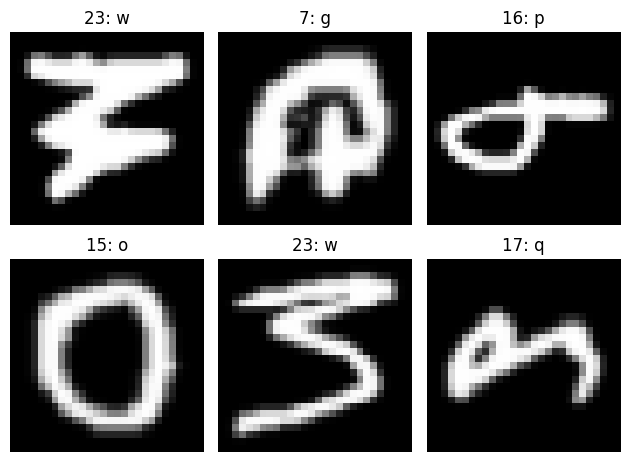

In [17]:
imageSubplot(imageArr, 6, first6alphabets)

From the images above, we can see that the images labelled 1-26 are the number-letter correspondence of the English alphabets. Hence we can conclude that the labels 1-26 are the alphabets' number-letter correspondence

However, we can see that our alphabets look slightly off. This is because the images are not in the correct orientation. We need to transpose them to the correct orientation (rotate 90 degrees clockwise + flip horizontally). We will do that by updating our createMatrix() function

## Image Transformation

In [18]:
def createMatrix(df):
    """
    Gets the pixel value from each row and reshapes it into a 28x28 matrix and transposes it
    """
    arr = []

    for row in range(len(df)):
        img = df.iloc[row, :].values.reshape((28, 28))
        arr.append(np.transpose(img))

    arr = np.array(arr)
    print(arr.shape)

    return arr

In [19]:
imageArr = createMatrix(df)

(99040, 28, 28)


Now let's visualise the transformed images and verify that they are in the correct orientation

### Blank Images

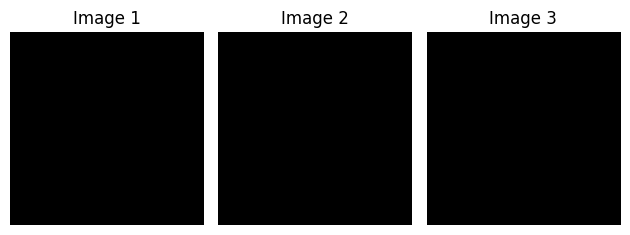

In [20]:
imageSubplot(blankArr, len(blankArr))

### Alphabet Images

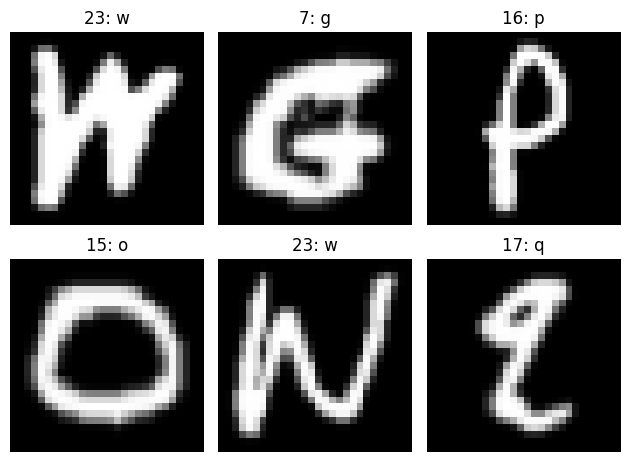

In [21]:
imageSubplot(imageArr, 6, first6alphabets)

### Alphabets 'a' and 'b'

Locate the indexes for the images labelled 1

In [22]:
df_original[df_original.iloc[:, 0] == 1].index

Index([  164,   184,   216,   220,   226,   233,   333,   336,   346,   387,
       ...
       98792, 98805, 98808, 98872, 98899, 98945, 98959, 98982, 98996, 99021],
      dtype='int64', length=3396)

In [23]:
aArr = [imageArr[164], imageArr[184], imageArr[216], imageArr[220], imageArr[226], imageArr[233]]

Locate the indexes for the images labelled 2

In [24]:
df_original[df_original.iloc[:, 0] == 2].index

Index([   35,    49,    78,   127,   142,   179,   193,   211,   222,   250,
       ...
       98607, 98640, 98649, 98717, 98749, 98834, 98860, 98913, 98971, 99006],
      dtype='int64', length=3396)

In [25]:
bArr = [imageArr[35], imageArr[49], imageArr[78], imageArr[127], imageArr[142], imageArr[179]]

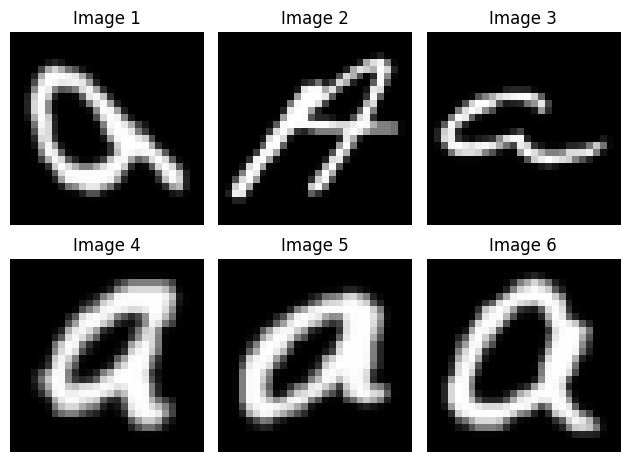

In [26]:
imageSubplot(aArr, len(aArr))

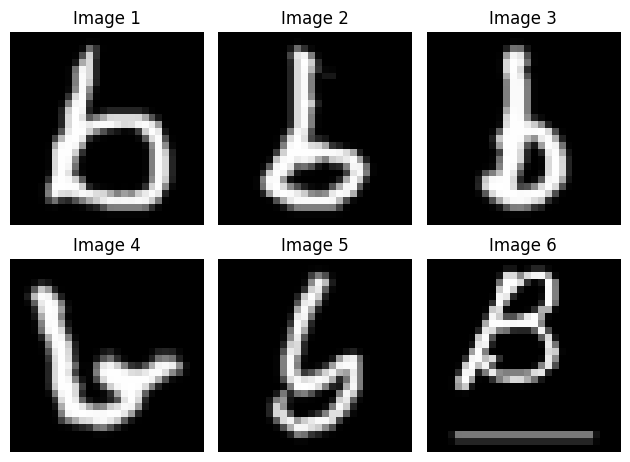

In [27]:
imageSubplot(bArr, len(bArr))

From the image plot above, we can see that for each alphabet there are lower and upper case. Our model will hence be able to generate both lower and upper case alphabet images

We have successfully verified that our transformation works and the images are now in the correct orientation. Our hypothesis about the first column being the labels and the rest of the columns being pixel values has been confirmed

## Convert Labels From Numbers To Alphabets

In [28]:
alphabets = alphabets.apply(lambda x: chr(x + 96) if x != -1 else 'blank')
alphabets.unique()

array(['w', 'g', 'p', 'o', 'q', 'm', 'k', 'v', 'x', 'j', 'n', 'r', 'u',
       'z', 's', 'e', 'blank', 'c', 'y', 'b', 'h', 'd', 't', 'i', 'f',
       'l', 'a'], dtype=object)

## Image Distribution

As our task is to generate images of the alphabets which do not include blank images, we should only focus on the images labelled 1-26 and ignore the blank images labelled -1

In [29]:
labels, counts = np.unique(alphabets, return_counts=True)
totalBlankImages = counts[np.where(labels == 'blank')]
totalAlphabetImages = np.sum(counts[np.where(labels != 'blank')])

In [30]:
numberOfImages = {}
for label, count in zip(labels, counts):
    numberOfImages[label] = count
numberOfImages

{'a': 3396,
 'b': 3396,
 'blank': 10240,
 'c': 3419,
 'd': 3398,
 'e': 3437,
 'f': 3394,
 'g': 3385,
 'h': 3424,
 'i': 3428,
 'j': 3402,
 'k': 3438,
 'l': 3415,
 'm': 3402,
 'n': 3365,
 'o': 3408,
 'p': 3430,
 'q': 3435,
 'r': 3419,
 's': 3392,
 't': 3436,
 'u': 3419,
 'v': 3422,
 'w': 3423,
 'x': 3437,
 'y': 3453,
 'z': 3427}

<Axes: xlabel='Alphabets', ylabel='count'>

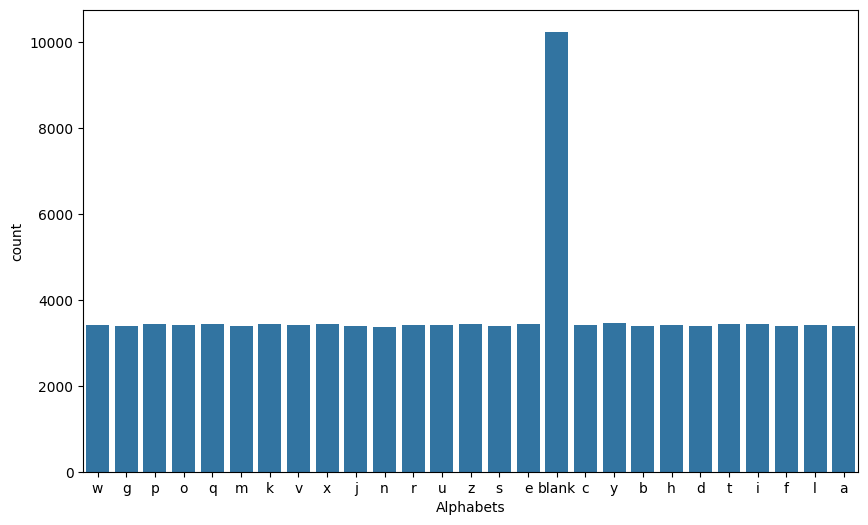

In [31]:
plt.figure(figsize=(10,6))
plt.xlabel('Alphabets')
sns.countplot(x=alphabets)

In [32]:
print(f'Average difference between blank and alphabet images: {(totalBlankImages - (totalAlphabetImages / len(counts)))[0]}')

Average difference between blank and alphabet images: 6951.111111111111


We can see that there is a huge difference (~7000 images) in the number of blank images compared to each the number of images for each alphabet. However, if we put into perspective the total number of alphabet images and the total number of blank images, will the difference still be significant?

In [33]:
print(f'Percentage: {round((totalBlankImages / totalAlphabetImages * 100)[0], 2)}%')

Percentage: 11.53%


Since the total number of blank images is just above 10% of the whole dataset, we can safely ignore the blank images and focus on the alphabet images since generating alphabet images is our main task

## Excluding Images Without Alphabets

In [34]:
df_without_blank = df_original[df_original.iloc[:, 0] != -1].drop(0, axis=1)
df_without_blank

,1,2,3,4,5,6,7,8,9,10,...,775,776,777,778,779,780,781,782,783,784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99032,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99035,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99036,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
withoutBlankArr = createMatrix(df_without_blank)

(88800, 28, 28)


## Alphabet Image Distribution

In [36]:
numberOfAlphabetImages = numberOfImages  # make a copy of the dictionary
numberOfAlphabetImages.pop('blank')  # remove the blank image counts
numberOfAlphabetImages

{'a': 3396,
 'b': 3396,
 'c': 3419,
 'd': 3398,
 'e': 3437,
 'f': 3394,
 'g': 3385,
 'h': 3424,
 'i': 3428,
 'j': 3402,
 'k': 3438,
 'l': 3415,
 'm': 3402,
 'n': 3365,
 'o': 3408,
 'p': 3430,
 'q': 3435,
 'r': 3419,
 's': 3392,
 't': 3436,
 'u': 3419,
 'v': 3422,
 'w': 3423,
 'x': 3437,
 'y': 3453,
 'z': 3427}

<Axes: xlabel='Alphabets', ylabel='count'>

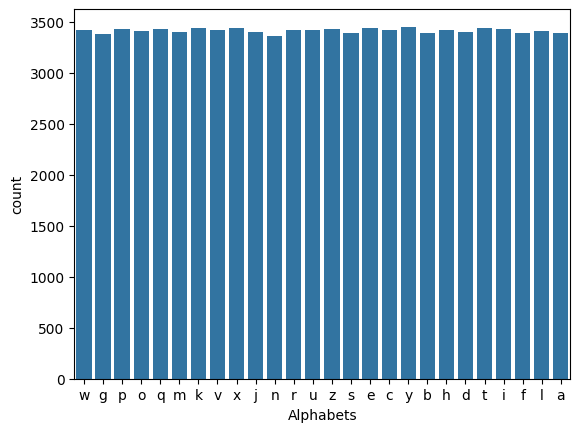

In [40]:
plt.xlabel('Alphabets')
sns.countplot(x=alphabets[alphabets != 'blank'])

We can see that there are no significant biases in the classes in the dataset. Hence, we do not need to worry about a class imbalance which may affect our model's performance

# Model Training

## DCGAN

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 6, 6, 64)          640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6, 6, 64)          0         
                                                                 
 dropout (Dropout)           (None, 6, 6, 64)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 3, 3, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 128)       

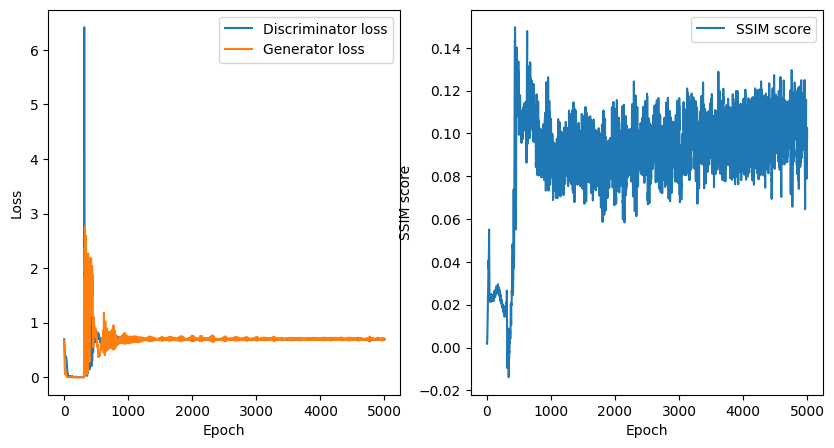

In [44]:
import numpy as np
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Reshape, Conv2DTranspose, Conv2D, LeakyReLU, Dropout, Flatten, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import os
import tensorflow as tf

class DCGAN:
    def __init__(self, rows, cols, channels, z=100):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z
        disc_optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        gen_optimizer = Adam(learning_rate=0.0001, beta_1=0.5)
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=disc_optimizer,
                                   metrics=['accuracy'])
        self.generator = self.build_generator()
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        self.discriminator.trainable = False
        valid = self.discriminator(img)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',
                              optimizer=gen_optimizer)

    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(7*7*256, use_bias=False, input_dim=self.latent_dim))
        model.add(BatchNormalization())
        model.add(ReLU())
        model.add(Reshape((7, 7, 256)))

        model.add(Conv2DTranspose(128, (1, 1), strides=(2, 2), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(ReLU())

        model.add(Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(ReLU())

        model.add(Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(ReLU())

        model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(ReLU())

        model.add(Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(Conv2D(64, kernel_size=3, strides=5, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def calculate_ssim(self, real_images, generated_images):
        ssim_scores = []
        for i in range(len(real_images)):
            score, _ = ssim(real_images[i], generated_images[i], full=True, data_range=real_images[i].max() - real_images[i].min())
            ssim_scores.append(score)
        return np.mean(ssim_scores)

    def train(self, epochs, batch_size=128, save_interval=50):
        # scale to [-1, 1]
        X_train = (withoutBlankArr - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        # Lists to store the losses and SSIM scores
        d_losses = []
        g_losses = []
        ssim_scores = []

        for epoch in range(epochs):
            # ---------------------
            # Train Discriminator
            # ---------------------
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            # Train the discriminator (it classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            d_losses.append(d_loss[0])  # Record the discriminator loss

            # ---------------------
            # Train Generator
            # ---------------------
            # Train the generator (it wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)
            g_losses.append(g_loss)  # Record the generator loss

            # Calculate SSIM score
            ssim_score = self.calculate_ssim(np.squeeze(imgs), np.squeeze(gen_imgs))
            ssim_scores.append(ssim_score)
            
            if epoch % save_interval == 0:
                print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss}] [SSIM: {ssim_score}]")
                self.save_imgs(epoch)

        # Plot loss curves and SSIM scores
        self.plot_scores(d_losses, g_losses, ssim_scores)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        if not os.path.exists('images'):
            os.makedirs('images')
        fig.savefig(f"images/mnist_{epoch}.png")
        plt.close()

    def plot_scores(self, d_losses, g_losses, ssim_scores):
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plt.plot(d_losses, label="Discriminator loss")
        plt.plot(g_losses, label="Generator loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(ssim_scores, label="SSIM score")
        plt.xlabel("Epoch")
        plt.ylabel("SSIM score")
        plt.legend()

        if not os.path.exists('plots'):
            os.makedirs('plots')
        plt.savefig("plots/loss_ssim.png")
        plt.show()

dcgan = DCGAN(28, 28, 1)
dcgan.train(epochs=5001, batch_size=256)

## CGAN

In [43]:
from numpy import expand_dims, zeros, ones, vstack
from numpy.random import randn, randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout
from matplotlib import pyplot
import numpy as np

# define the standalone discriminator model
def define_discriminator(in_shape=(28, 28, 1)):
    model = Sequential()
    # normal
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 256 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 256)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer
    model.add(Conv2D(1, (7,7), activation='tanh', padding='same'))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

def load_real_samples():
    # Assuming withoutBlankArr is a numpy array of shape (num_samples, 28, 28)
    X = (withoutBlankArr - 127.5) / 127.5
    X = np.expand_dims(X, axis=-1)  # Expand to (num_samples, 28, 28, 1)
    return X.astype('float32')

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray')
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=101, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    # to store losses
    d_loss1_list, d_loss2_list, g_loss_list = [], [], []

    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            # record losses
            d_loss1_list.append(d_loss1)
            d_loss2_list.append(d_loss2)
            g_loss_list.append(g_loss)
            
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
                
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
    
    # plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(d_loss1_list, label='d_loss_real')
    plt.plot(d_loss2_list, label='d_loss_fake')
    plt.plot(g_loss_list, label='g_loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Discriminator and Generator Loss')
    plt.savefig('loss_plot.png')
    plt.close()

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)


2/2 [==============================] - 0s 13ms/step
>1, 1/693, d1=0.695, d2=0.695 g=0.692
2/2 [==============================] - 0s 12ms/step
>1, 2/693, d1=0.597, d2=0.700 g=0.686
2/2 [==============================] - 0s 12ms/step
>1, 3/693, d1=0.513, d2=0.713 g=0.673
2/2 [==============================] - 0s 12ms/step
>1, 4/693, d1=0.425, d2=0.745 g=0.645
2/2 [==============================] - 0s 12ms/step
>1, 5/693, d1=0.337, d2=0.802 g=0.601
2/2 [==============================] - 0s 11ms/step
>1, 6/693, d1=0.260, d2=0.893 g=0.551
2/2 [==============================] - 0s 14ms/step
>1, 7/693, d1=0.217, d2=1.004 g=0.524
2/2 [==============================] - 0s 13ms/step
>1, 8/693, d1=0.228, d2=1.010 g=0.544
2/2 [==============================] - 0s 11ms/step
>1, 9/693, d1=0.269, d2=0.946 g=0.614
2/2 [==============================] - 0s 12ms/step
>1, 10/693, d1=0.303, d2=0.822 g=0.706
2/2 [==============================] - 0s 12ms/step
>1, 11/693, d1=0.340, d2=0.688 g=0.841
2/2 [===

KeyboardInterrupt: 